#Predicting Equipment Failure and Scheduling Maintenance Proactively

## Problem Statement

<p>
Equipment failure is a major cause of downtime in the telecommunications industry, which can
result in significant financial losses and customer dissatisfaction. To minimize downtime and
ensure optimal performance, it is crucial to identify potential equipment failures and schedule
maintenance accordingly proactively. This requires the collection and analysis of large amounts
of data generated by various equipment and network sensors.
</p>

<p>
The deliverable for this project is a data pipeline that can efficiently collect, clean, and analyze
equipment and network sensor data. The pipeline should be designed to identify potential
equipment failures and schedule maintenance proactively, minimizing downtime and improving
overall equipment performance. <b>The data pipeline will be built using Python and PostgreSQL
and with the Postgres database hosted on Google Cloud</b>
</p>

###Step1 - Data Extraction 

Sample datasets for data extraction have been provided by the client and will be used for building the pipeline.

In [ ]:
import pandas as pd 
import logging

#Setup logger
logging.basicConfig(filename='pipeline.log', level=logging.DEBUG)

#Initialize the dataframes to be used
dset1 = pd.DataFrame()
dset2 = pd.DataFrame()
dset3 = pd.DataFrame()


In [ ]:
#Use Python to read the CSV files and extract the data.


def readCsv(f1, f2, f3):

  """
  Function to read data from csv files and return df for each file
  Takes 3 arguments - respective csv filenames
  """

  try:
    dset1 = pd.read_csv(f1)
    dset2 = pd.read_csv(f2)
    dset3 = pd.read_csv(f3)

  except Exception as e:
    logging.debug("Method readCsv exception occurred")
  
  return dset1,dset2,dset3

In [ ]:
dset1, dset2,dset3 = readCsv('equipment_sensor.csv','maintenance_records.csv', 'network_sensor.csv' )
#dset3.shape

###Step3 - Data Transformation

The collected data must be cleaned and transformed to ensure
consistency and quality. This will involve removing duplicates, fixing missing data, and normalizing the data for consistency.

In [ ]:
###3.1 - Checking for missing values
n1 = dset1.isnull().sum()
n2 = dset2.isnull().sum()
n3 = dset3.isnull().sum()

print(f"Equipment_sensor.csv null count: \n{n1}, \nMaintenance_records.csv null count: \n{n2}, \nNetwork_sensor.csv null count: \n{n3}  ")

Equipment_sensor.csv null count: 
ID                0
date              0
time              0
sensor_reading    0
dtype: int64, 
Maintenance_records.csv null count: 
ID                  0
date                0
time                0
equipment_ID        0
maintenance_type    0
dtype: int64, 
Network_sensor.csv null count: 
ID                0
date              0
time              0
sensor_reading    0
dtype: int64  


In [ ]:
###3.2 - Checking datatypes
print(f"Equipment_sensor.csv data types: \n{dset1.dtypes}, \nMaintenance_records.csv data types: \n{dset2.dtypes}, \nNetwork_sensor.csv data types: \n{dset3.dtypes}  ")

Equipment_sensor.csv data types: 
ID                  int64
date               object
time               object
sensor_reading    float64
dtype: object, 
Maintenance_records.csv data types: 
ID                   int64
date                object
time                object
equipment_ID         int64
maintenance_type    object
dtype: object, 
Network_sensor.csv data types: 
ID                  int64
date               object
time               object
sensor_reading    float64
dtype: object  


In [ ]:
###3.3 - Datatypes conversion

def transformDF(dset1, dset2, dset3):

  """ 
  Function arguments is 3 dataframes from extracted data
  Data conversion for these columns on equipment_sensor df: date, time
  Data conversion for these columns on maintenance_records df: date, time, maintenance_type  
  Data conversion for these columns on network_sensor: date, time 
  Returns 3 cleaned dfs 
  """

  try:

    #dset1
    dset1['date'] = dset1['date'] + " " + dset1['time']
    dset1['date'] = pd.to_datetime(dset1['date'])
    dset1 = dset1.drop(columns=['time'])
    
    
    #dset2
    dset2['maintenance_type'] = dset2['maintenance_type'].astype("category")
    dset2['date'] = dset2['date'] + " " + dset2['time']
    dset2['date'] = pd.to_datetime(dset2['date'])
    dset2 = dset2.drop(columns=['time'])

    #dset3
    dset3['date'] = dset3['date'] + " " + dset3['time']
    dset3['date'] = pd.to_datetime(dset3['date'])
    dset3 = dset3.drop(columns=['time'])

    #fix duplicate column names in dfs to avoid mixup later
    dset1 = dset1.rename(columns={"sensor_reading": "equipment_reading"})
    dset1 = dset1.rename(columns={"date": "date_e"})
    dset2 = dset2.rename(columns={"date": "date_m"})
    dset3 = dset3.rename(columns={"sensor_reading": "network_reading"})
    dset3 = dset3.rename(columns={"date": "date_n"})

  except Exception as e:
    logging.debug("Method transformDF exception occurred")

  return dset1, dset2, dset3


In [ ]:
dset1, dset2, dset3 = transformDF(dset1, dset2, dset3)

In [ ]:
#dset2.dtypes
#dset3.dtypes
#dset1.dtypes

In [ ]:
###3.4 - Aggregation - explore mean of sensor findings

def aggregator(dset1, dset3):

  """
  Data aggregation function to get average sensor reading. 
  Takes equipment sensor df and network sensor df arguments, returns df with mean values
  """
  try:
    mean_esensor = dset1.groupby('ID')['equipment_reading'].mean()
    mean_nsensor = dset3.groupby('ID')['network_reading'].mean()
    
    frame = { 'Average_Equipment_Sensor': mean_esensor, 'Average_Network_Sensor': mean_nsensor }

    mean_df = pd.DataFrame(frame)

  except Exception as e:
    logging.debug("Method aggregator exception occurred")

  return mean_df



In [ ]:
means = aggregator(dset1, dset3)
means

,Average_Equipment_Sensor,Average_Network_Sensor
ID,,
1,27.633333,0.600000
2,98.266667,0.873333


###Step 4 - Merge the datasets

Join the different datasets into a single dataset that can be used for
analysis.

In [ ]:
###4.1 Merge datasets 

def mergeDF(dset1, dset3):
  """
  Function takes 2 dfs as arguments
  Concat the 2 dfs and return joined df
  """

  try:
    dset3 = dset3.drop(columns=['ID'])
    df_merge = pd.concat([dset1,dset3 ], axis=1)
   
  except Exception as e:
    logging.debug("Method mergeDF exception occurred")

  return df_merge



In [ ]:
df_join = mergeDF(dset1, dset3)

In [ ]:
df_join

,ID,date_e,equipment_reading,date_n,network_reading
0,1,2022-03-01 08:00:00,26.7,2022-03-01 08:00:00,0.58
1,1,2022-03-01 08:15:00,28.4,2022-03-01 08:15:00,0.62
2,1,2022-03-01 08:30:00,27.8,2022-03-01 08:30:00,0.60
3,2,2022-03-01 08:00:00,99.1,2022-03-01 08:00:00,0.89
4,2,2022-03-01 08:15:00,97.5,2022-03-01 08:15:00,0.85
5,2,2022-03-01 08:30:00,98.2,2022-03-01 08:30:00,0.88


In [ ]:
###Generate csv file
df_join.to_csv("merge1.csv", index=False)

###Step 5 - Data loading to psql instance on Google cloud

In [ ]:
#install psql library
!pip install psycopg2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
###5.1 load the data to postgresql db on google cloud

import psycopg2
import numpy as np
import psycopg2.extras as extras


def loadToPSQL(df_join):

  """
  Function to upload the merged data in df_join to google cloud hosted postgreSQL database
  Takes 1 argument - the joined df
  """

  try:
    conn = psycopg2.connect(
        host="35.188.99.146",
        database="moringa-psql1",
        user="postgres",
        password="Siri@2022"
    )

    # create a cursor object
    cur = conn.cursor()

    #If table exists, drop and create anew
    sql0 ="DROP TABLE sensors2"
    sql1='''CREATE TABLE sensors2(ID int not null,date_e varchar(255),equipment_reading int,date_n varchar(255),\
    network_reading float(4));'''

    cur.execute(sql0)
    cur.execute(sql1)

    # execute a SQL query
    tuples = [tuple(x) for x in df_join.to_numpy()]
    
    cols = ','.join(list(df_join.columns))
    # SQL query to execute
    query = "INSERT INTO %s(%s) VALUES %%s" % ('sensors2', cols)

    extras.execute_values(cur, query, tuples)
    conn.commit()
    print("Function loadToPSQL() -- Data successfully uploaded to gcloud\n\n")
  
  except Exception as e:
    print("Error: %s" % e)
    conn.rollback()
  
  # close the cursor and connection
  cur.close()
  conn.close()



##### Confirming data uploaded on gcloud dbase

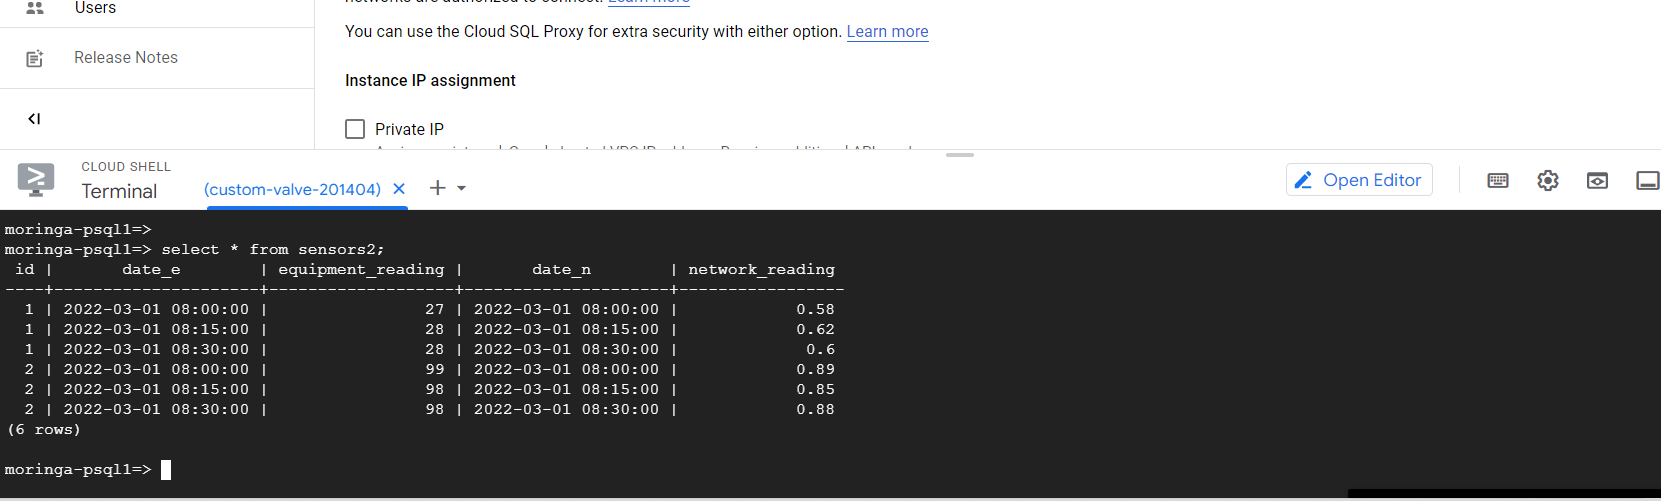

In [ ]:
###5.2 Fetch data from gcloud psql databse 

def fetchData():

  """
  Function that fetches data back from postgreSQL database hosted on gCloud
  Takes no arguments
  """

  try:
    conn = psycopg2.connect(
        host="35.188.99.146",
        database="moringa-psql1",
        user="postgres",
        password="Siri@2022"
    )

    # create a cursor object
    cur = conn.cursor()

    sql2 = "select * from sensors2"
    cur.execute(sql2)

    print("Function fetchData() -- Fetching data from gCloud database ")
    # fetch the results
    rows = cur.fetchall()

    for r in rows:
      print(r)

  except Exception as e:
    print("Error: %s" % e)

  # close the cursor and connection
  cur.close()
  conn.close()



###Step 6 - Automating the process 

In [ ]:

if __name__ == '__main__':

    #Extract Data
    dset1, dset2,dset3 = readCsv('equipment_sensor.csv','maintenance_records.csv', 'network_sensor.csv' )
    #Use assert test to confirm only dataframes returned
    assert(type(dset1).__name__ == 'DataFrame')
    assert(type(dset2).__name__ == 'DataFrame')
    assert(type(dset3).__name__ == 'DataFrame')

    #Transform the data 
    dset1, dset2, dset3 = transformDF(dset1, dset2, dset3)
    #confirm returned df
    assert(type(dset1).__name__ == 'DataFrame')
    assert(type(dset2).__name__ == 'DataFrame')
    assert(type(dset3).__name__ == 'DataFrame')
  
    #Aggregation
    means = aggregator(dset1, dset3)
    assert(type(means).__name__ == 'DataFrame')

    #Merge the datasets
    df_join = mergeDF(dset1, dset3)
    assert(type(df_join).__name__ == 'DataFrame')

    #Load data to gCloud psql database
    loadToPSQL(df_join)

    #Fetch gcloud db contents and print
    fetchData()



Function loadToPSQL() -- Data successfully uploaded to gcloud


Function fetchData() -- Fetching data from gCloud database 
(1, '2022-03-01 08:00:00', 27, '2022-03-01 08:00:00', 0.58)
(1, '2022-03-01 08:15:00', 28, '2022-03-01 08:15:00', 0.62)
(1, '2022-03-01 08:30:00', 28, '2022-03-01 08:30:00', 0.6)
(2, '2022-03-01 08:00:00', 99, '2022-03-01 08:00:00', 0.89)
(2, '2022-03-01 08:15:00', 98, '2022-03-01 08:15:00', 0.85)
(2, '2022-03-01 08:30:00', 98, '2022-03-01 08:30:00', 0.88)


Use steps below to automate script using cron job.
This cron job will execute above pipeline script every Monday at 9am.

1- run 'crontab -e'
<br>2- append below text, save and close file 

0 9 * * 1 /path/to/this/pipelinescript.py # Run Mondays 0900hrs